In [1]:
import numpy as np
import pandas as pd
import data_analysis_temp as da
import plotly.express as px
import plotly.graph_objects as go
from ast import literal_eval
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image


In [2]:
user_data, top50 = da.load_data()

/Users/leksa/Documents/MIR/TSAI Hackathon/data-visualisation-web/src/data_analysis_temp.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_50 = top_50.append(df, ignore_index=True)
/Users/leksa/Documents/MIR/TSAI Hackathon/data-visualisation-web/src/data_analysis_temp.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_50 = top_50.append(df, ignore_index=True)
/Users/leksa/Documents/MIR/TSAI Hackathon/data-visualisation-web/src/data_analysis_temp.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_50 = top_50.append(df, ignore_index=True)
/Users/leksa/Documents/MIR/TSAI Hackathon/data-visualisation-web/src/data_analysis_temp.py:23: FutureWarning: The frame.append method is deprecated and will be removed from

### User Based Analysis

In [4]:
qualitative = ['artist_names','genres','key','mode','speechiness','liveness','user_id']
quantative_normalizable = ['popularity', 'danceability', 'energy', 'loudness','speechiness',
       'acousticness', 'instrumentalness', 'valence', 'mode']
quantative_not_normalizable = ['tempo', 'duration_ms','user_id']
# relative way of normalizing - more distinctive result / shows more persona
quantative_normalized = top50[quantative_normalizable].apply(lambda x: (x - x.mean())/x.std(), axis = 0)
# absolute way of normalizing - range is [0,1], less distinctive result / a couple of features are similar among users: energy, loudness, valence, etc. 
# quantative_normalized = (top50[quantative_normalizable] - top50[quantative_normalizable].min())/(top50[quantative_normalizable].max()-top50[quantative_normalizable].min())
quantative_top50 = pd.concat([top50[quantative_not_normalizable],quantative_normalized], axis = 1 )

##### Averaging each feature for each user
user_average_data = quantative_top50.groupby(["user_id"]).mean()
user_average_data = user_average_data.join(top50[["user_id", "artist_names","genres"]].groupby(["user_id"]).nunique(), on = 'user_id')
# using 3 criteria: 
# 1. popularity
# 2. dance music lover: 0.6 * danceability + 0.3 * loudness + 0.3 * energy - 0.2 * acousticness
# 3. musical positiveness: 0.8 * valence + 0.2 * mode
# mode -> 1: major key, mode -> 0: minor key
user_average_data["dance_music_lover"] = user_average_data["danceability"] * 0.6 + user_average_data["loudness"] * 0.3 + user_average_data["energy"] * 0.3 - user_average_data["acousticness"] * 0.2
user_average_data["musical_positiveness"] = user_average_data["valence"] * 0.8 + user_average_data["mode"] * 0.2


##### Plotting

fig = px.scatter_3d(user_average_data, x = 'dance_music_lover', y = 'musical_positiveness', z = 'popularity', color = 'tempo', size = 'genres', size_max = 18,
                    opacity = 0.7)

fig.update_layout(margin = dict(l=0, r=0, b=0, t=0))

### Genre and Artist Based

/var/folders/qz/tdx4m00s7kjbwb7x7ts61f5m0000gn/T/ipykernel_17417/1950085548.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/qz/tdx4m00s7kjbwb7x7ts61f5m0000gn/T/ipykernel_17417/1950085548.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{'pop': 90, 'dance pop': 56, 'electropop': 54, 'edm': 52, 'electro house': 44, 'escape room': 41, 'brazilian metal': 40, 'power metal': 40, 'neo classical metal': 39, 'metal': 38, 'brazilian power metal': 37, 'melodic metal': 37, 'pop dance': 35, 'brazilian progressive metal': 35, 'progressive power metal': 35, 'hip hop': 33, 'rap': 32, 'pop edm': 32, 'uk pop': 27, 'tropical house': 27, 'alternative r&b': 24, 'art pop': 24, 'r&b': 23, 'indie soul': 22, 'desi pop': 20, 'pop rap': 20, 'electronic trap': 16, 'indie poptimism': 16, 'timba': 16, 'alt z': 15, 'modern rock': 14, 'filmi': 14, 'salsa cubana': 13, 'otacore': 13, 'modern bollywood': 13, 'indie pop': 12, 'future bass': 12, 'house': 12, 'vapor twitch': 11, 'afrofuturism': 11, 'complextro': 11, 'brostep': 10, 'metropopolis': 10, 'desi hip hop': 10, 'rock': 10, 'gaming edm': 9, 'modern salsa': 9, 'vapor soul': 9, 'post-teen pop': 9, 'alternative hip hop': 9, 'neo soul': 9, 'bass trap': 9, 'trap': 8, 'transpop': 8, 'progressive house'

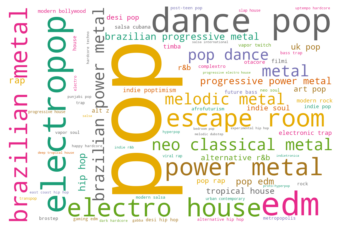

{'Shaman': 33, 'Jeff Williams': 13, 'Casey Lee Williams': 10, 'Anime': 7, 'Mecánik Informal': 6, 'Skrillex': 6, 'Havana D’Primera': 6, 'Alexander Abreu': 6, 'Taylor Swift': 5, 'Tyler, The Creator': 5, 'Eminem': 4, 'Ashnikko': 4, 'Kelela': 4, 'Laura Les': 4, '100 gecs': 4, 'Dylan Brady': 4, 'KAYTRANADA': 4, 'TroyBoi': 3, 'Gurinder Gill': 3, 'Doja Cat': 3, 'Clairo': 3, 'DLMT': 3, 'DROELOE': 3, 'ILLENIUM': 3, 'Gym Class Heroes': 3, 'Death Grips': 3, 'Grimes': 3, 'Gorillaz': 3, 'Poppy': 3, 'AP Dhillon': 3, 'Giraldo Piloto y Klímax': 3, 'Alex Abraham': 3, 'Joyner Lucas': 2, 'Juan Formell y Los Van Van': 2, 'Lexie Liu': 2, 'The Marías': 2, 'Madison Beer': 2, 'Charlotte Day Wilson': 2, 'Anderson .Paak': 2, 'Miguel': 2, 'Dua Lipa': 2, 'Borgore': 2, 'Kali Uchis': 2, 'Jorja Smith': 2, 'Jessie Ware': 2, 'Mumford & Sons': 2, 'Flying Lotus': 2, 'Disco Fries': 2, 'Steve Goldshein': 2, 'Cookiee Kawaii': 2, 'Janelle Monáe': 2, 'Curbi': 2, 'Jamila Woods': 2, 'A$AP Rocky': 2, 'Daft Punk': 2, 'Quinn XCII

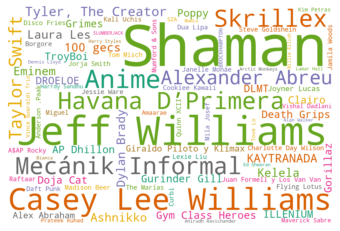

In [5]:
###### Dataframe Cleanup
artist_genre_song = top50[["artist_names", "genres", "name"]]
artist_genre_song["artist_names"] = artist_genre_song["artist_names"].apply(literal_eval)
artist_genre_song["genres"] = artist_genre_song["genres"].apply(literal_eval)
artist_genre_song = artist_genre_song.explode('artist_names')
artist_genre_song = artist_genre_song.explode('genres')
artist_genre_song = artist_genre_song.explode('genres')

###### Creating Ranking for Genres & Artists respectively
genre_rank = artist_genre_song[["genres", "name"]].groupby(["genres"]).nunique().sort_values(by = 'name', ascending=False)
genre_rank = genre_rank[genre_rank["name"] > 5]

artist_rank = artist_genre_song[["artist_names", "name"]].groupby(["artist_names"]).nunique().sort_values(by = 'name', ascending=False)
artist_rank = artist_rank[artist_rank["name"] != 1]

###### Generating WordCloud

for i in [genre_rank, artist_rank]:
    d = i.to_dict()["name"]
    print(d)
    
    wordcloud = WordCloud(width = 1200, height = 800, background_color = 'white', colormap = 'Dark2')
    wordcloud.generate_from_frequencies(d)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


